In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
torch.cuda.empty_cache()
exp_dir   = "F:/PhD_Projects/MZA_Cluster_Models/Exp6.1_KS_seqlentest"
# pickle.load(open("Trained_Models/Cluster_Models/Exp4.2.4_Transient_2DCyl_MULTISTEP_numobstest_with_seqmodel_switch/sl33_nhu40_numobs3_bs16_lr5e-5_ph10/args"))
models = []


exp_name_list = [
                 "sl5_nhu40_numobs16_bs16_lr5e-5_ph24",\
                 "sl9_nhu40_numobs16_bs16_lr5e-5_ph24",\
                 "sl17_nhu40_numobs16_bs16_lr5e-5_ph24",\
                 "sl25_nhu40_numobs16_bs16_lr5e-5_ph24",\
                 "sl33_nhu40_numobs16_bs16_lr5e-5_ph24",\
                 "sl65_nhu40_numobs16_bs16_lr5e-5_ph24",\
                 "sl129_nhu40_numobs16_bs16_lr5e-5_ph24",\
                 "sl257_nhu40_numobs16_bs16_lr5e-5_ph24",\
                
                 ]
for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

sl5_nhu40_numobs16_bs16_lr5e-5_ph24
sl9_nhu40_numobs16_bs16_lr5e-5_ph24
sl17_nhu40_numobs16_bs16_lr5e-5_ph24
sl25_nhu40_numobs16_bs16_lr5e-5_ph24
sl33_nhu40_numobs16_bs16_lr5e-5_ph24
sl65_nhu40_numobs16_bs16_lr5e-5_ph24
sl129_nhu40_numobs16_bs16_lr5e-5_ph24
sl257_nhu40_numobs16_bs16_lr5e-5_ph24


In [4]:
models[0].deactivate_seqmodel

False

Epoch with Minimum train_error:  360


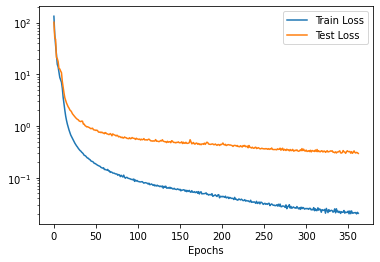

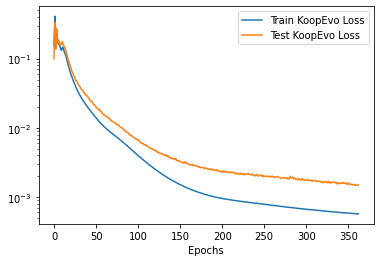

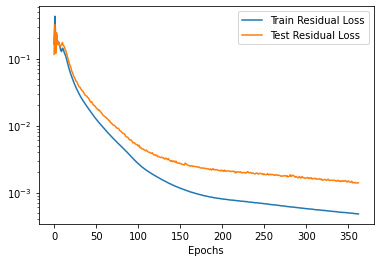

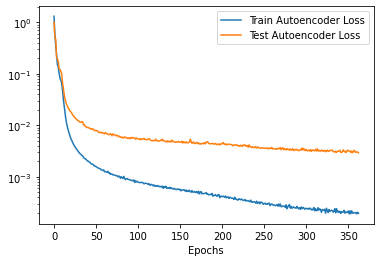

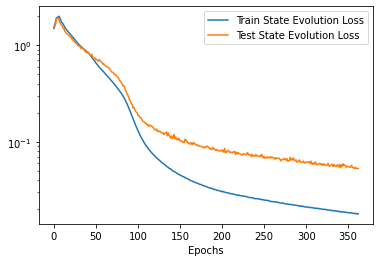

In [60]:
#plot learning curves
models[4].plot_learning_curves()

In [6]:
for i in range(0,len(models)):
    epoch_num = 7999
    models[i].load_weights(epoch_num, True)

In [7]:
# for i in range(0,len(models)):

ph0 = models[0].pred_horizon 
models[0].pred_horizon = 1

In [9]:
#One Step Prediction
model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Test")
dataset = models[model_num].test_dataset
num_trajs = models[model_num].test_num_trajs

# eval_mza.train_size = 0.9
for i in range(1):#len(models)):
    i=model_num
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape

models[0].pred_horizon = ph0




Data Shape:  (1, 27000, 128)
Not normalizing Input
out of train
Test_Shape:  (1, 5400, 128)
torch.Size([1, 5399, 16]) torch.Size([1, 5399, 128]) torch.Size([1, 5399, 128])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [31]:
Phi = models[0].test_data

Text(0, 0.5, 'MSE')

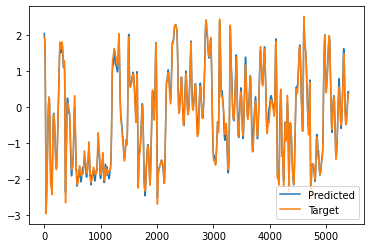

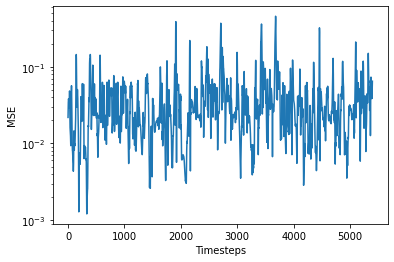

In [10]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "Target")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

In [45]:
#multistep prediction
timesteps = 700
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i], xkoop_hat_temp, xseq_hat_temp = models[i].predict_multistep(initial_conditions, timesteps)
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)


ic shape: torch.Size([1, 128])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([8, 1, 701, 128]) torch.Size([8, 1, 700, 128])


Text(0, 0.5, 'kinetic energy')

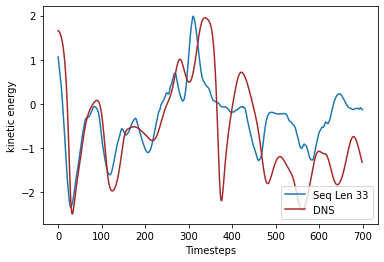

In [58]:
plt.figure()
for i in [4]:
    
    plt.plot(Phi_ms_hat[i,0,:,8].detach().cpu().numpy(), label = f"Seq Len {models[i].seq_len}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(Phi[0,initial_step:timesteps+initial_step,6], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

In [ ]:
def energy(u,v):
    k = 0.5*(np.mean(u**2,axis=-1) + np.mean(v**2,axis=-1))
    return k

k_pred = energy(U_nn,V_nn)
k = energy(U, V)

Text(0, 0.5, 'Observables $  L_{2} Norm$')

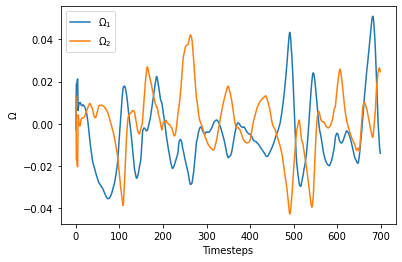

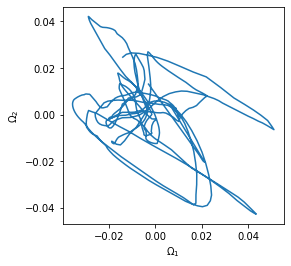

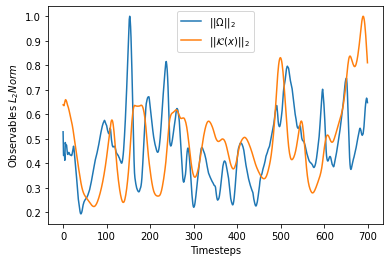

In [59]:
#plotting mode evolution
plt.figure()
model_num = 0
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(xseq_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\Omega$"+f"$_{n+1}$")

plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\Omega$")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xseq_ms_hat[model_num][0,:,0].cpu().numpy(), xseq_ms_hat[model_num][0,:,1].cpu().numpy())
plt.xlabel(f"$\Omega_{1}$")
plt.ylabel(f"$\Omega_{2}$")

plt.figure()
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)

plt.plot((tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:], label = r"$||\Omega||_{2}$")
plt.plot((tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:], label = r"$||\mathcal{K}(x)||_{2}$")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("Observables " + r"$  L_{2} Norm$")

torch.Size([1, 5399, 128]) torch.Size([8, 1, 21, 128])


Text(0, 0.5, 'MSE')

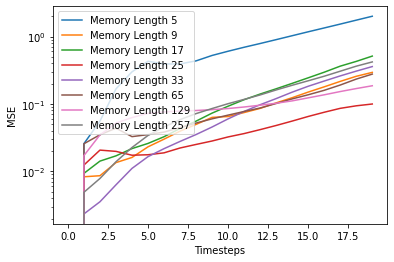

In [17]:
print(Phi_nn.shape, Phi_ms_hat.shape)
State_MSE_multistep = torch.zeros((len(models),timesteps))

plt.figure()
for i in [0,1,2,3,4,5,6,7]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    # if i!=len(models)-1:
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Memory Length {models[i].seq_len}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

In [ ]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
for i in [0,1,2,3,4,5,6,7]:
    
    plt.plot(k_ms_pred[i,0,:], label = f"Number of Hidden Units {models[i].num_hidden_units}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

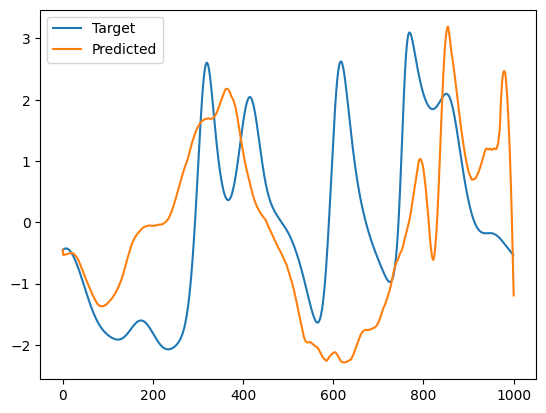

In [9]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn.cpu().numpy()[i,:timesteps,0], '-', label = "Target")
    plt.plot(Phi_hat.cpu().numpy()[i,:,0], '-', label = "Predicted")
    plt.legend()



torch.Size([1, 9900, 256]) torch.Size([1, 1001, 256])


Text(0, 0.5, 'MSE')

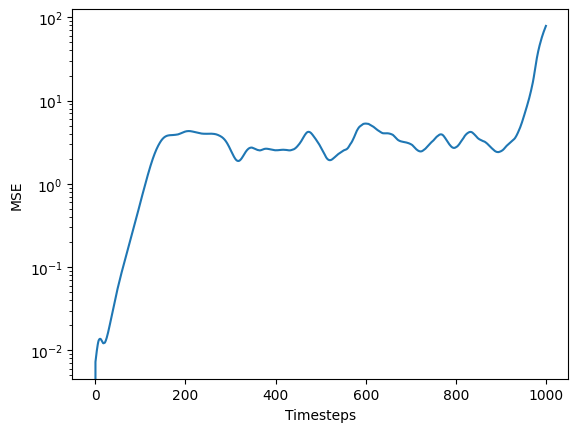

In [10]:
print(Phi_nn.shape, Phi_hat.shape)
State_MSE_multistep = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_hat[:,:timesteps])
plt.figure()
plt.semilogy(State_MSE_multistep.detach().cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

Text(0.5, 0, 'Epochs')

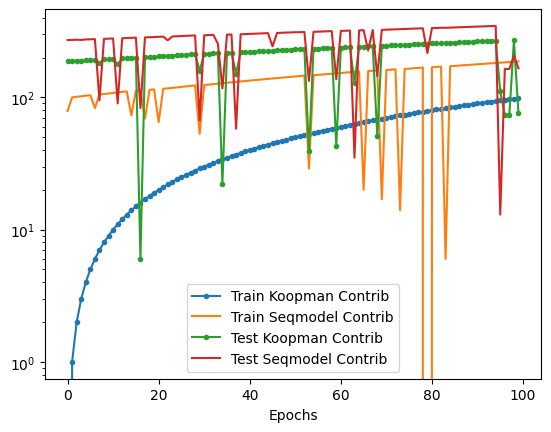

In [15]:
plt.figure()
plt.semilogy(df['epoch'],df['Train_koop_ptg'], '.-',label="Train Koopman Contrib")
plt.semilogy(df['epoch'],df['Train_seqmodel_ptg'], label="Train Seqmodel Contrib")

plt.semilogy(df['epoch'], df['Test_koop_ptg'], '.-',label="Test Koopman Contrib")
plt.semilogy(df['epoch'], df['Test_seqmodel_ptg'], label="Test Seqmodel Contrib")

plt.legend()
# plt.savefig(self.exp_dir+'/'+self.exp_name+"/out_log/")
plt.xlabel("Epochs")

[ 1.0012703 +0.j          0.9925952 +0.j          0.95846   +0.j
  0.90255255+0.05272212j  0.90255255-0.05272212j  0.78605855+0.11712778j
  0.78605855-0.11712778j  0.32256153+0.5027797j   0.32256153-0.5027797j
  0.13909923+0.j          0.06070239+0.j         -0.41360974+0.4998098j
 -0.41360974-0.4998098j  -0.6303705 +0.j         -0.6874748 +0.20136683j
 -0.6874748 -0.20136683j]
[ 1.0006974 +0.j          0.99004763+0.j          0.9446541 +0.j
  0.89109397+0.08353023j  0.89109397-0.08353023j  0.8822825 +0.j
  0.56726307+0.26314214j  0.56726307-0.26314214j  0.48645496+0.j
  0.07167289+0.08736757j  0.07167289-0.08736757j -0.3150402 +0.5130011j
 -0.3150402 -0.5130011j  -0.6495032 +0.17196965j -0.6495032 -0.17196965j
 -0.69283086+0.j        ]
[ 1.0000192 +0.j          0.9877752 +0.j          0.9762832 +0.j
  0.9528481 +0.j          0.9134438 +0.j          0.90858954+0.j
  0.8515717 +0.j          0.39829907+0.j          0.2518106 +0.j
  0.2013068 +0.21405265j  0.2013068 -0.21405265j -0.382211

Text(0, 0.5, '$Img(\\lambda)$')

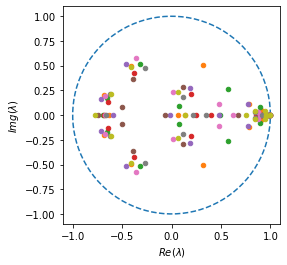

In [15]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', label = "Unit Circle")

for i in [0,1,2,3,4,5,6,7]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), ".", markersize = 9, label = f"Num Observables {models[i].num_obs}")

plt.xlabel(r"$Re(\lambda)$")
plt.ylabel(r"$Img(\lambda)$")
# plt.legend()

array([ 1.2694882e-01  +0.j       , -7.4323559e-01  +0.j       ,
       -4.2427478e+00  +0.j       , -1.0082516e+01  +5.8348155j,
       -1.0082516e+01  -5.8348155j, -2.2974400e+01 +14.791811j ,
       -2.2974400e+01 -14.791811j , -5.1524319e+01+100.03798j  ,
       -5.1524319e+01-100.03798j  , -1.9725677e+02  +0.j       ,
       -2.8017725e+02  +0.j       , -4.3270039e+01+226.21024j  ,
       -4.3270039e+01-226.21024j  , -4.6144753e+01+314.15927j  ,
       -3.3357384e+01+285.6655j   , -3.3357384e+01-285.6655j   ],
      dtype=complex64)

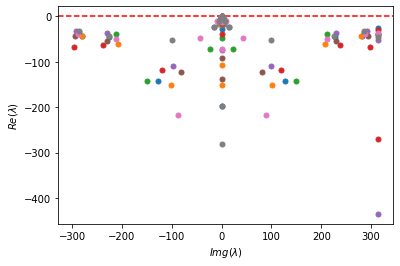

In [18]:
plt.figure()

plt.axhline(0, color='red', linestyle='--')

# plt.text(0.17, 0.075, 'x = 0.17', color='green')
for i in [7,6,5,4,3,2,1,0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.01)
    plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", markersize = 10, label = f"Num Observables {models[i].num_obs}")

plt.ylabel(r"$Re(\lambda)$")
plt.xlabel(r"$Img(\lambda)$")

# plt.ylim(-0.1,0.1)
# plt.xlim(-1,1)
# plt.legend()
lamb

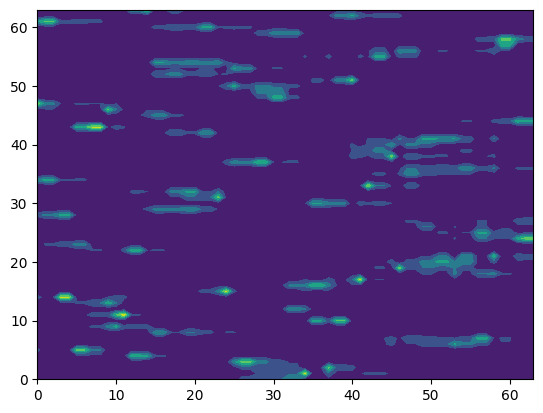

In [56]:
plt.contourf(abs(v))